# Evaluation vorticity 8x -> 2.2km
## Diff model
Vorticity transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max then just square (so nothing "clever" with negative values)

In [1]:
%reload_ext autoreload

%autoreload 2

import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree

In [2]:
run_name = "2.2km-coarsened-8x_london_vorticity850_random-transform-data"
checkpoint_id = 200
dataset_name = "2.2km-coarsened-8x_london_vorticity850_random"
split = "val"

pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', run_name, f'samples/checkpoint-{checkpoint_id}', split, 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))

merged_ds = xr.merge([pred_ds, eval_ds], join="inner")

In [3]:
merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, sample_id: 9, bnds: 2,
                                 grid_latitude: 32, grid_longitude: 32)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
    forecast_period             (time) timedelta64[ns] 452 days 12:00:00 ... ...
    forecast_reference_time     (time) object 1979-09-01 00:00:00 ... 2059-09...
    realization                 (time) int32 1100000 1100000 ... 1100000 1100000
    pressure                    (time) float32 850.0 850.0 850.0 ... 850.0 850.0
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * grid_latitude               (grid_latitude) float32 -1.58 -1.56 ... -0.9599
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 361.5
  * sample_id                   (sample_id) int64 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (sample_id, time) float64 -2.147e+09 ... -2.1...
    time_bnds                   (sample_id, time, bnds) object 1980-12-03 00:...
    grid_latitude_bnds          (sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (sample_id, time, grid_longitude, bnds) float32 ...
    forecast_period_bnds        (sample_id, time, bnds) float64 1.085e+04 ......
    pred_pr                     (sample_id, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 4320, 32, 32), meta=np.ndarray>
    target_pr                   (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...

## Samples

In [4]:
timestamps = np.random.choice(merged_ds["time"], size=10, replace=False)
# timestamps = merged_ds.sum(dim=['grid_latitude', 'grid_longitude']).sortby('target_pr')["time"][-20:-10]

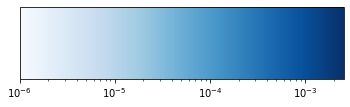

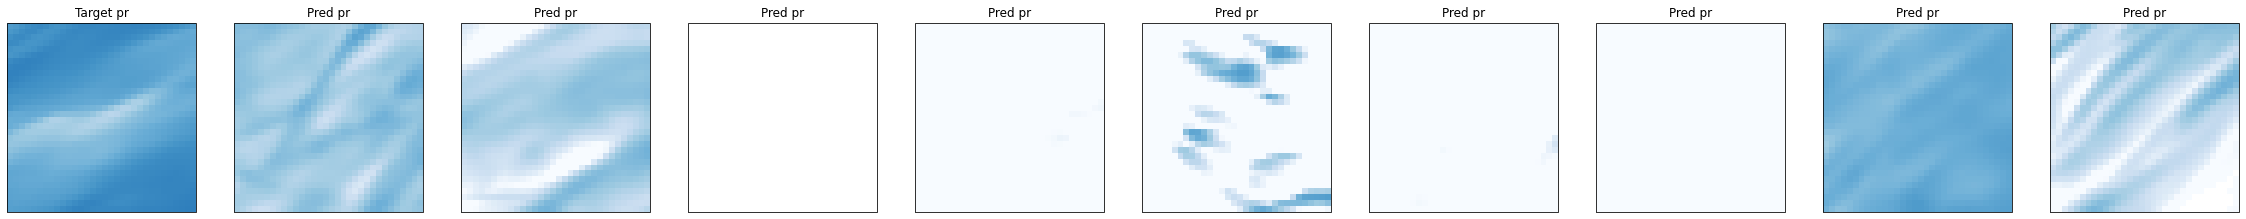

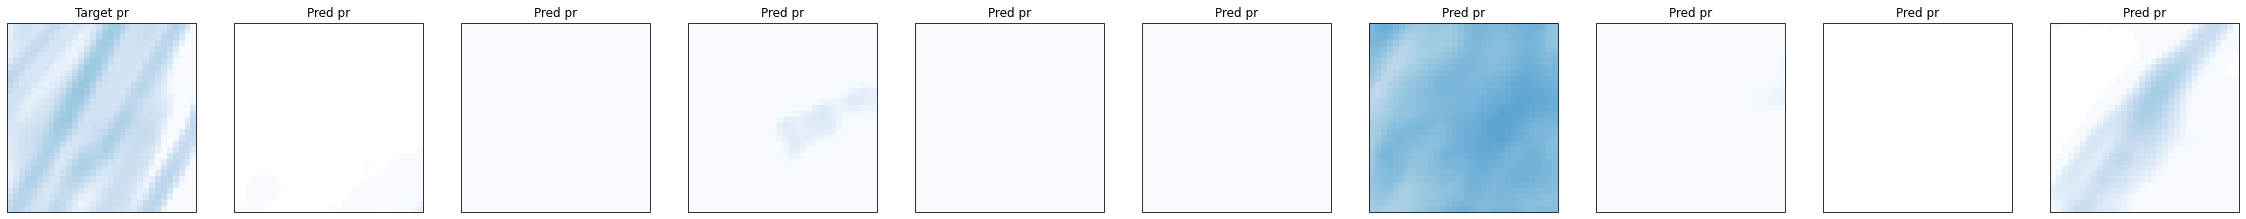

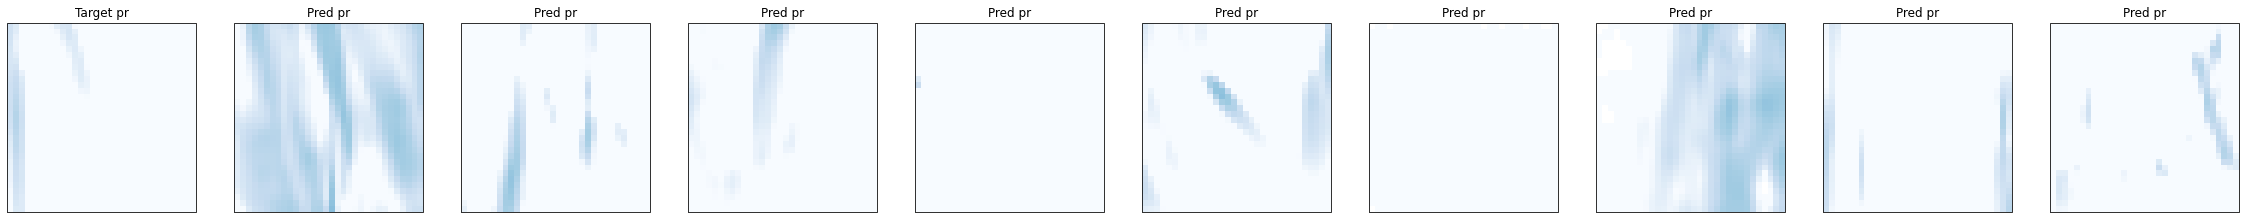

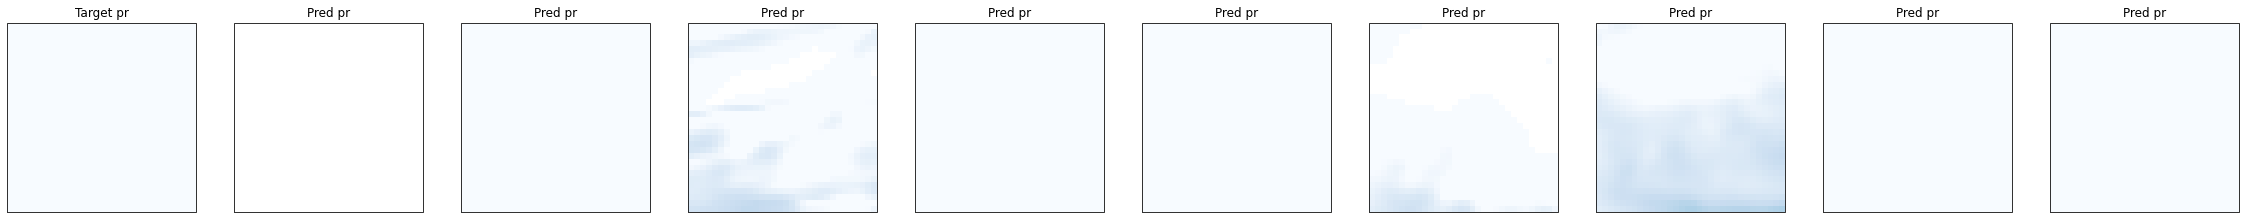

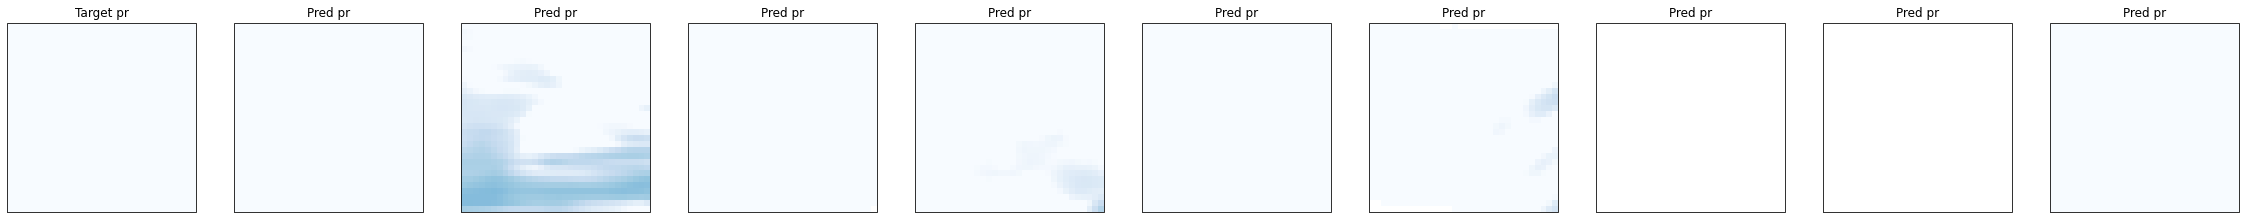

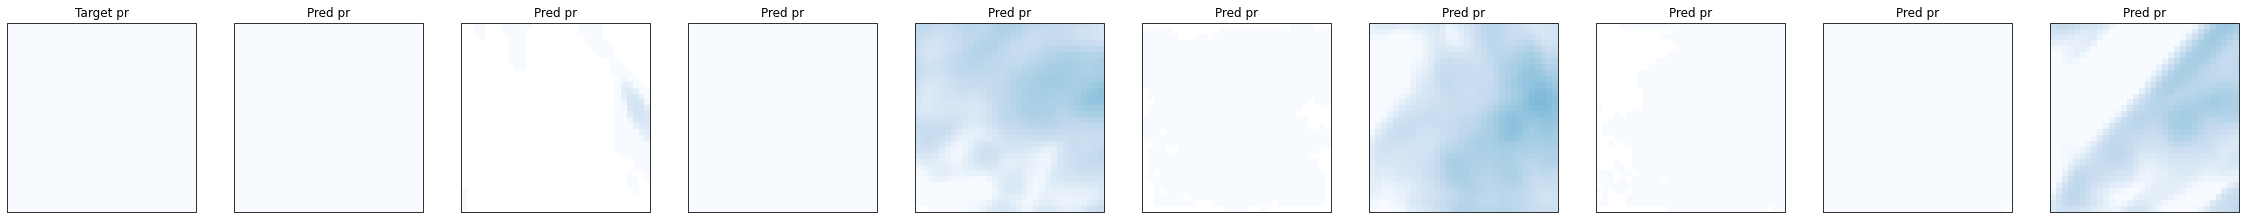

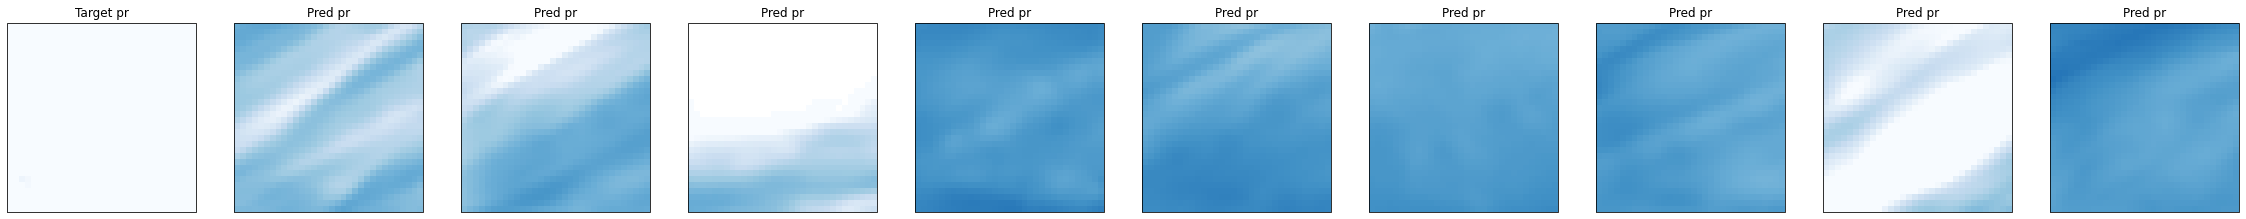

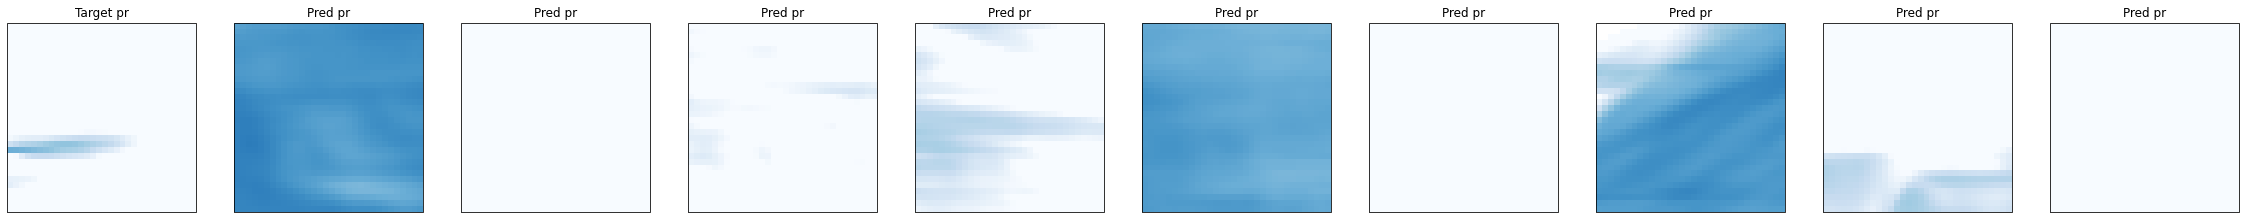

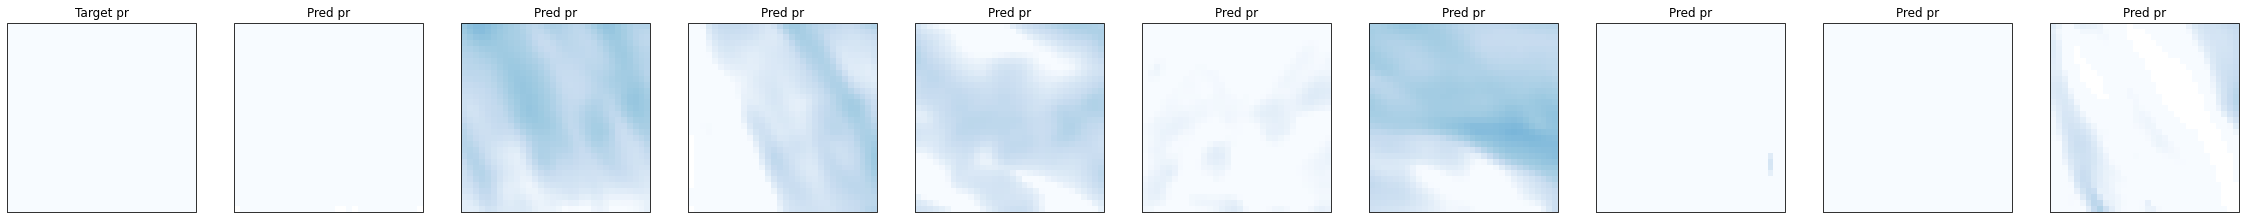

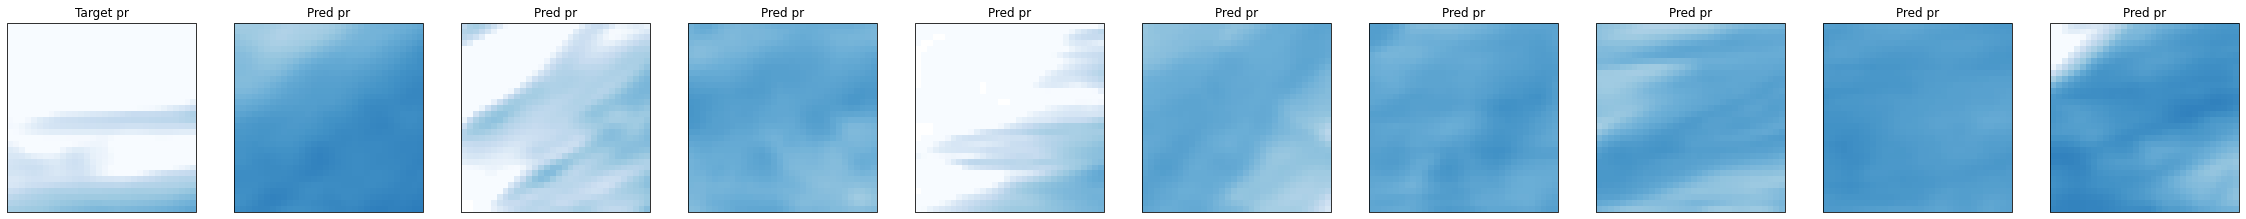

In [6]:
# vmin = min([merged_ds['pred_pr'].min().values])
vmin = min([merged_ds['target_pr'].min().values])
vmin = 1e-6
vmax = max(merged_ds['pred_pr'].max().values, merged_ds['target_pr'].max().values)

# s_m = matplotlib.cm.ScalarMappable(cmap="Blues", norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
fig = plt.figure(figsize=(5, 10))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', cmap='Blues', norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
plt.show()

def plot_pr(da, ax, title="", vmin=None, vmax=None, add_colorbar=False, cmap='Blues'):
    da.plot(ax=ax, norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=add_colorbar, cmap=cmap)
    # da.plot(ax=ax, add_colorbar=True, cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    
def show_predictions(ds, timestamps):
    num_predictions = len(ds["sample_id"])
    
    num_plots_per_ts = num_predictions+1 # plot each sample and true target pr
    
    for ts in timestamps:
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_pr(ds.sel(time=ts)["target_pr"], ax, title="Target pr", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in ds["sample_id"]:
            ax = axes[1+sample_id]
            plot_pr(ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, title="Pred pr", vmin=vmin, vmax=vmax, add_colorbar=False)
            # ds.sel(time=ts, sample_id=sample_id)["pred_pr"].plot(ax=ax, norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=False, cmap='Blues')
            
        
        plt.show()


show_predictions(merged_ds, timestamps)

## Density

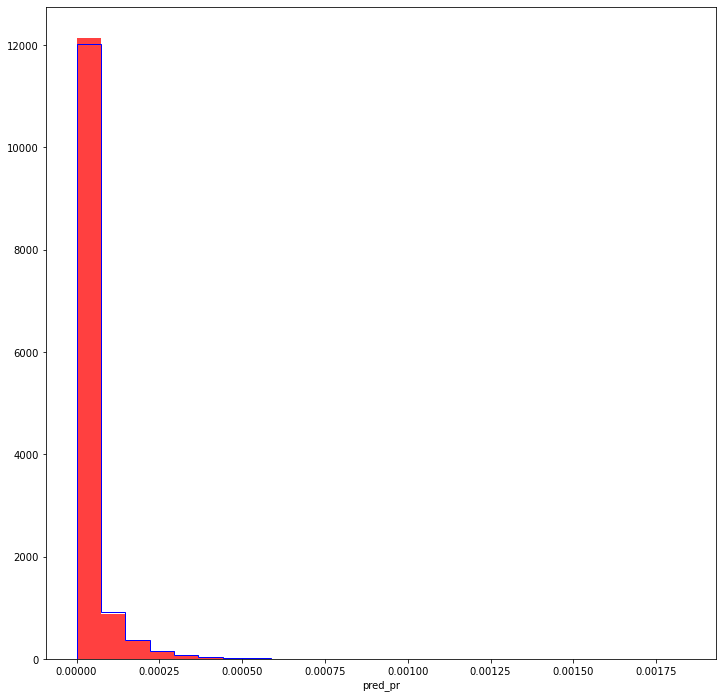

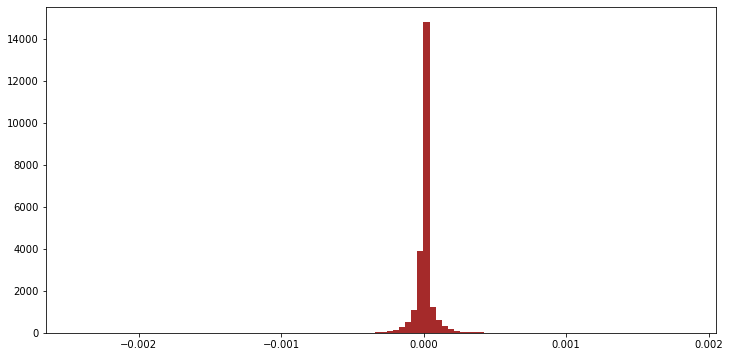

In [7]:
plt.figure(figsize=(12,12))
_, bins, _ = merged_ds['target_pr'].plot(bins=25, density=True,alpha=1, color="blue", histtype="step")
merged_ds['pred_pr'].plot(bins=bins, density=True,alpha=0.75, color="red")

plt.show()

plt.figure(figsize=(12,6))
(merged_ds['target_pr'] - merged_ds["pred_pr"]).plot(bins=100, density=True, color="brown")
plt.show()

## Scatter

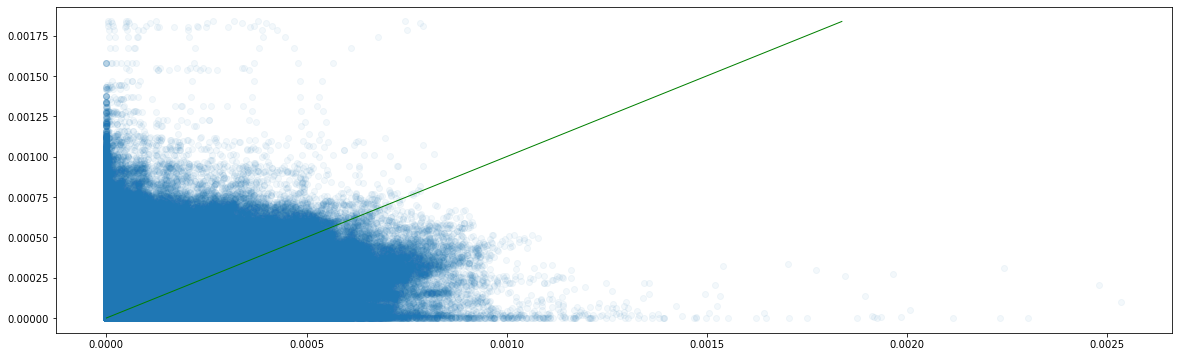

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(20, 6))

tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


ax = axs

ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
ax.plot([0, tr], [0, tr], linewidth=1, color='green')


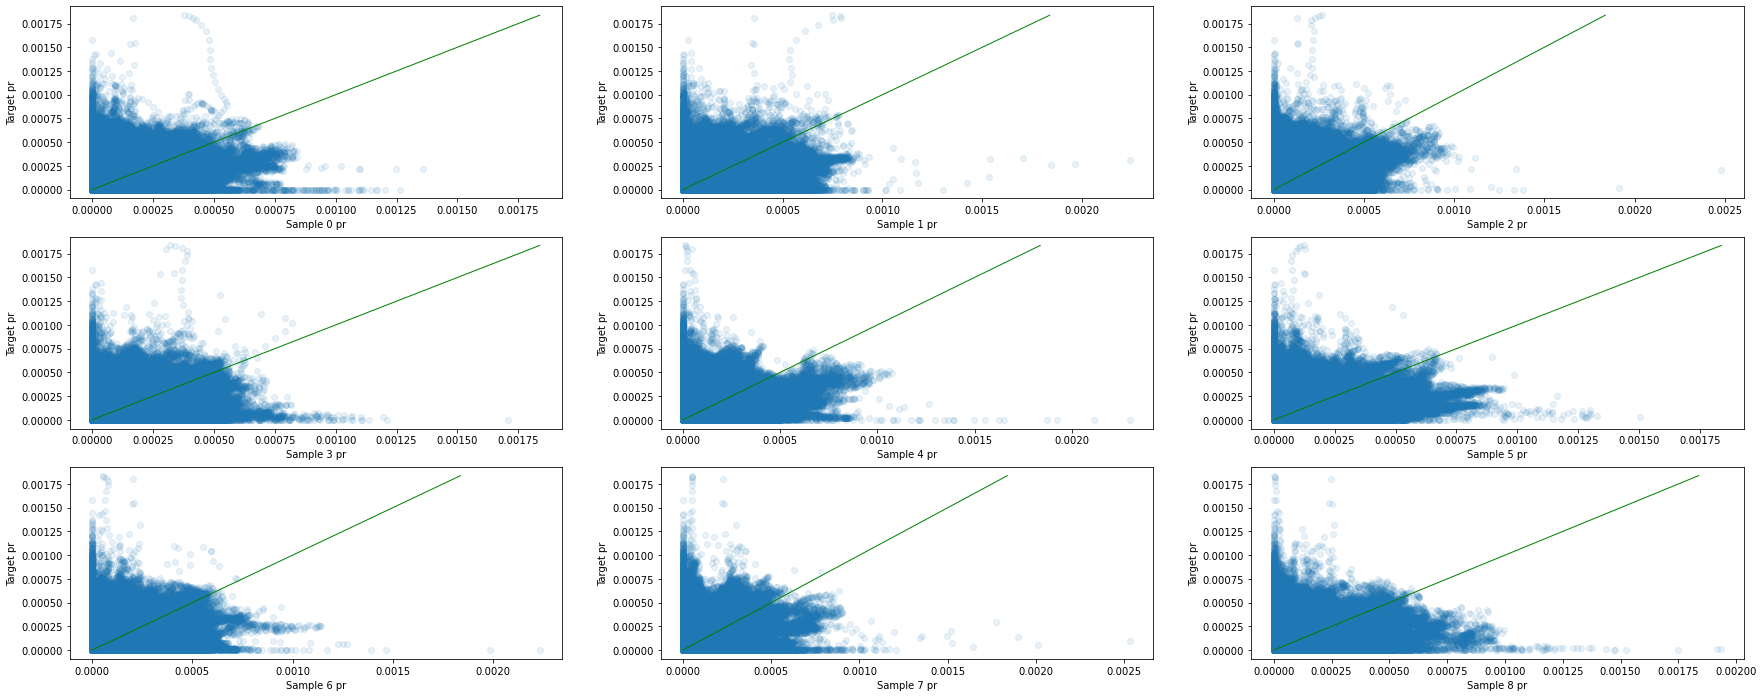

In [9]:
sample_ids = np.arange(9).reshape(3, 3)

fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

for i, sample_id in enumerate(sample_ids.flatten()):
    ax = axs[i//3][i%3]

    ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
    ax.plot([0, tr], [0, tr], linewidth=1, color='green')
    ax.set_xlabel(f"Sample {sample_id} pr")
    ax.set_ylabel(f"Target pr")

## Means

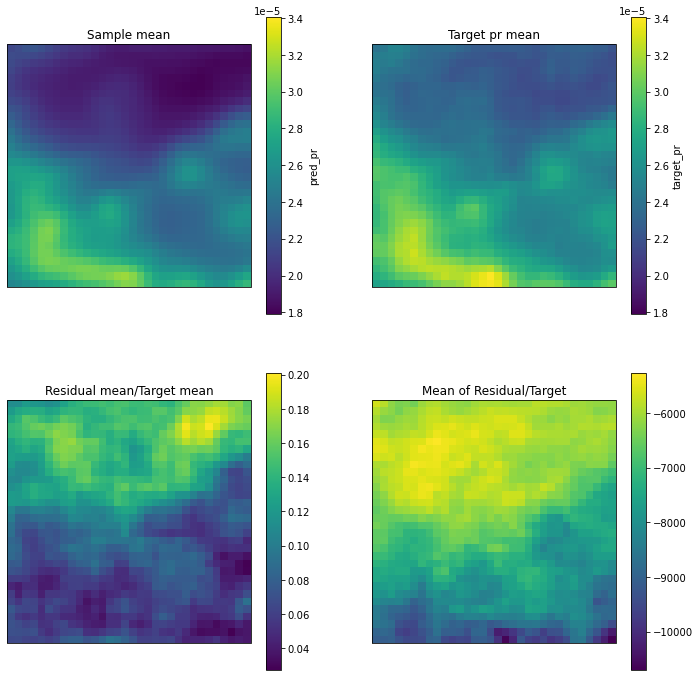

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection=cp_model_rotated_pole))

sample_mean = merged_ds['pred_pr'].mean(dim=["sample_id", "time"])
target_mean = merged_ds['target_pr'].mean(dim="time")
residuals = merged_ds['target_pr'] - merged_ds['pred_pr']
residual_mean = residuals.mean(dim=["sample_id", "time"])

vmin = min([da.min().values for da in [sample_mean, target_mean]])
vmax = max([da.max().values for da in [sample_mean, target_mean]])

ax = axs[0][0]
sample_mean.plot(ax=ax, vmax=vmax, vmin=vmin)
ax.set_title("Sample mean")
ax.coastlines()

ax = axs[0][1]
target_mean.plot(ax=ax, vmax=vmax, vmin=vmin)
ax.set_title("Target pr mean")
ax.coastlines()

ax = axs[1][0]
(residual_mean/target_mean).plot(ax=ax)
ax.set_title("Residual mean/Target mean")
ax.coastlines()

ax = axs[1][1]
(residuals/(merged_ds['target_pr']+1e-10)).mean(dim=["sample_id", "time"]).plot(ax=ax)
ax.set_title("Mean of Residual/Target")
ax.coastlines()

plt.show()


## Standard deviation

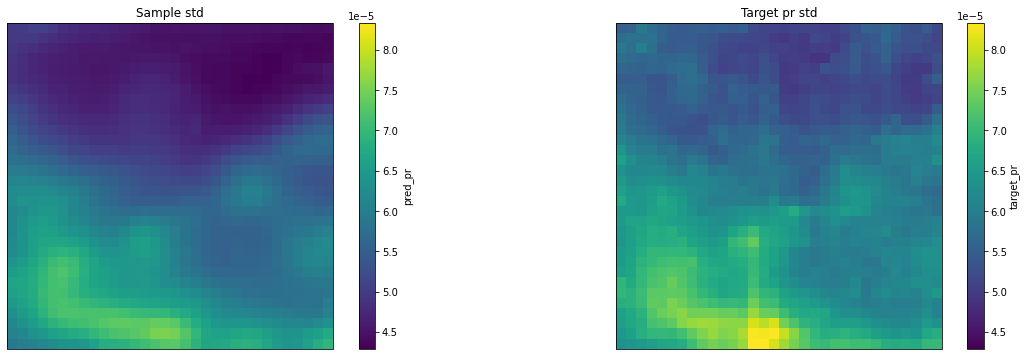

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), subplot_kw=dict(projection=cp_model_rotated_pole))

sample_std = merged_ds['pred_pr'].std(dim=["sample_id", "time"])
target_std = merged_ds['target_pr'].std(dim="time")
# residual_mean = (merged_ds['target_pr'] - merged_ds['pred_pr'].mean(dim="sample_id")).mean(dim="time")

vmin = min([da.min().values for da in [sample_std, target_std]])
vmax = max([da.max().values for da in [sample_std, target_std]])

ax = axs[0]
sample_std.plot(ax=ax, vmax=vmax, vmin=vmin)
ax.set_title("Sample std")
ax.coastlines()

ax = axs[1]
target_std.plot(ax=ax, vmax=vmax, vmin=vmin)
ax.set_title("Target pr std")
ax.coastlines()

plt.show()

## Total precip

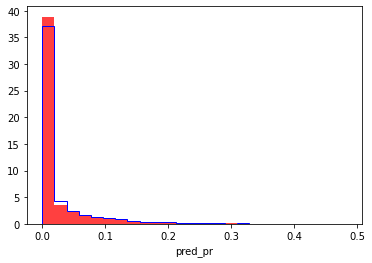

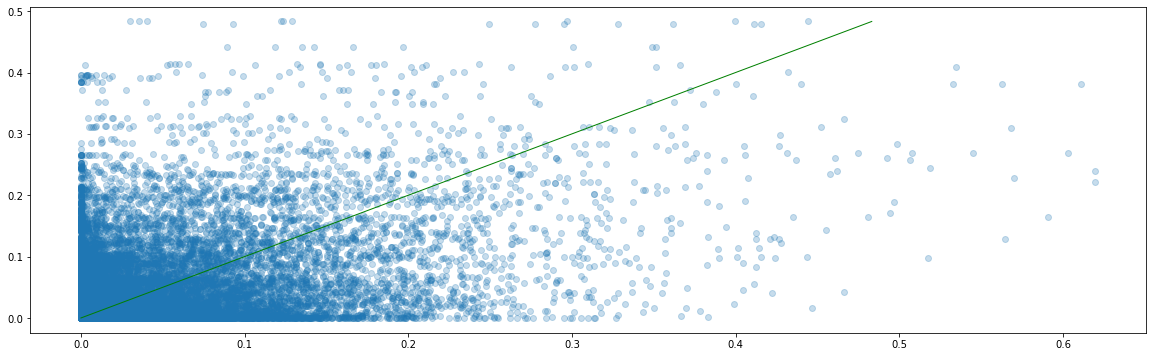

In [13]:
total_pred_pr = merged_ds["pred_pr"].sum(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sum(dim=["grid_longitude", "grid_latitude"])

_, bins, _ = total_target_pr.plot.hist(alpha=1, bins=25, density=True, color="blue", histtype="step")
total_pred_pr.plot.hist(alpha=0.75, bins=bins, color="red", density=True)

plt.show()

# ((total_target_pr - total_pred_pr)/total_target_pr).plot.hist(bins=100)

fig, axs = plt.subplots(1, 1, figsize=(20, 6))

tr = min(total_pred_pr.max(), total_target_pr.max())


ax = axs

ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
ax.plot([0, tr], [0, tr], linewidth=1, color='green')

plt.show()

## PSD

In [131]:
import pysteps

Pysteps configuration file found at: /home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/pysteps/pystepsrc



In [137]:
pysteps.utils.spectral.rapsd(merged_ds["target_pr"].isel(time=0).values)

array([2.3762689e-10, 2.0079652e-10, 2.0330171e-10, 2.2021780e-10,
       2.3060477e-10, 2.6753849e-10, 2.6953129e-10, 3.2918138e-10,
       2.6452504e-10, 2.1139611e-10, 2.0110921e-10, 1.9626886e-10,
       1.8464520e-10, 1.6606588e-10, 2.3976518e-10, 2.4676119e-10,
       2.8028832e-10], dtype=float32)